In [1]:
import os
print("Current working directory:", os.getcwd())

#os.chdir("/Users/lucatognari/Pitone/File-di-python/Trus")  # Change to your desired path

Current working directory: /users/lanza/cvision


In [2]:
!git clone https://github.com/wwu-mmll/c-trus.git

fatal: destination path 'c-trus' already exists and is not an empty directory.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BlurPool(nn.Module):
    def __init__(self, channels, filt_size=3, stride=2):
        super().__init__()
        self.stride = stride
        self.channels = channels
        
        if filt_size == 3:
            a = torch.tensor([1., 2., 1.])
        elif filt_size == 5:
            a = torch.tensor([1., 4., 6., 4., 1.])
        
        a = a / a.sum()
        filt = a[:, None] * a[None, :]  # 2D kernel
        filt = filt[None, None, :, :].repeat(channels, 1, 1, 1)
        
        self.register_buffer('filt', filt)
        self.pad = nn.ReflectionPad2d(filt_size // 2)
    
    def forward(self, x):
        x = self.pad(x)
        return F.conv2d(x, self.filt, stride=self.stride, groups=self.channels)


class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, use_se=True):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.se = SEBlock(out_channels) if use_se else nn.Identity()
        self.relu = nn.ReLU(inplace=True)
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x):
        return self.relu(self.se(self.conv(x)) + self.residual(x))

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512], dropout=0.2, deep_supervision=True, use_se=True, use_blurpool=True):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.deep_supervision = deep_supervision
        
        # Downsampling path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, use_se=use_se))
            if use_blurpool:
                self.pools.append(BlurPool(feature, filt_size=3, stride=2))
            else:
                self.pools.append(nn.Conv2d(feature, feature, kernel_size=3, 
                                           stride=2, padding=1))
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            DoubleConv(features[-1], features[-1]*2, use_se=use_se),
            nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        )
        
        # Upsampling path
        for feature in reversed(features):
            self.ups.append(nn.Sequential(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2),
                nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
            ))
            self.ups.append(DoubleConv(feature*2, feature, use_se=use_se))
            self.attention_blocks.append(AttentionBlock(F_g=feature, F_l=feature, F_int=feature // 2))
        
        # Final output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        # Deep supervision outputs
        if deep_supervision:
            self.deep_outputs = nn.ModuleList([
                nn.Conv2d(feature, out_channels, kernel_size=1) 
                for feature in reversed(features)
            ])
    
    def forward(self, x):
        skip_connections = []
        
        # Down path
        for i, down in enumerate(self.downs):
            x = down(x)
            skip_connections.append(x)
            x = self.pools[i](x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Reverse skip connections
        skip_connections = skip_connections[::-1]
        
        deep_outputs = []
        
        # Up path with attention
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=False)
            
            attn = self.attention_blocks[idx // 2](x, skip_connection)
            concat_skip = torch.cat((attn, x), dim=1)
            x = self.ups[idx + 1](concat_skip)
            
            if self.deep_supervision and self.training and idx // 2 < len(self.deep_outputs):
                deep_outputs.append(self.deep_outputs[idx // 2](x))
        
        final_out = self.final_conv(x)
        
        if self.deep_supervision and self.training:
            return final_out, deep_outputs
        return final_out

Refined Model 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BlurPool(nn.Module):
    """Anti-aliasing blur pooling layer"""
    def __init__(self, channels, filt_size=3, stride=2):
        super().__init__()
        self.stride = stride
        self.channels = channels
        
        if filt_size == 3:
            a = torch.tensor([1., 2., 1.])
        elif filt_size == 5:
            a = torch.tensor([1., 4., 6., 4., 1.])
        
        a = a / a.sum()
        filt = a[:, None] * a[None, :]  # 2D kernel
        filt = filt[None, None, :, :].repeat(channels, 1, 1, 1)
        
        self.register_buffer('filt', filt)
        self.pad = nn.ReflectionPad2d(filt_size // 2)
    
    def forward(self, x):
        x = self.pad(x)
        return F.conv2d(x, self.filt, stride=self.stride, groups=self.channels)


class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, max(channels // reduction, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(max(channels // reduction, 1), channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class AttentionBlock(nn.Module):
    """Spatial attention gate for skip connections"""
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class RefinedSkipConnection(nn.Module):
    """
    Refine skip connections before concatenation.
    Reduces noise and improves feature quality.
    """
    def __init__(self, channels):
        super().__init__()
        self.refine = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.se = SEBlock(channels)
    
    def forward(self, skip):
        skip_refined = self.refine(skip)
        skip_refined = self.se(skip_refined)
        return skip_refined


class DoubleConv(nn.Module):
    """
    Double convolution with residual connection, SE block, and stratified dropout.
    """
    def __init__(self, in_channels, out_channels, use_se=True, dropout_rate=0.0):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.se = SEBlock(out_channels) if use_se else nn.Identity()
        self.relu = nn.ReLU(inplace=True)
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) \
                       if in_channels != out_channels else nn.Identity()
    
    def forward(self, x):
        return self.relu(self.se(self.conv(x)) + self.residual(x))


class DilatedDoubleConv(nn.Module):
    """
    Dilated double convolution for increased receptive field.
    Used in bottleneck for multi-scale context.
    """
    def __init__(self, in_channels, out_channels, dilation=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                      padding=dilation, dilation=dilation),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,
                      padding=dilation, dilation=dilation),
            nn.BatchNorm2d(out_channels),
        )
        self.se = SEBlock(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.residual = nn.Conv2d(in_channels, out_channels, 1) \
                       if in_channels != out_channels else nn.Identity()
    
    def forward(self, x):
        return self.relu(self.se(self.conv(x)) + self.residual(x))


class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512], 
                 dropout=0.2, deep_supervision=True, use_se=True, use_blurpool=True,
                 use_skip_refinement=True, dropout_rate=0.1):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()
        self.refined_skips = nn.ModuleList() if use_skip_refinement else None
        self.deep_supervision = deep_supervision
        self.use_skip_refinement = use_skip_refinement
        
        # Downsampling path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, use_se=use_se, 
                                         dropout_rate=dropout_rate))
            if use_blurpool:
                self.pools.append(BlurPool(feature, filt_size=3, stride=2))
            else:
                self.pools.append(nn.Conv2d(feature, feature, kernel_size=3, 
                                           stride=2, padding=1))
            in_channels = feature
        
        # Bottleneck with dilated convolutions for larger receptive field
        self.bottleneck = nn.Sequential(
            DilatedDoubleConv(features[-1], features[-1]*2, dilation=2),
            nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        )
        
        # Upsampling path
        for feature in reversed(features):
            self.ups.append(nn.Sequential(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2),
                nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
            ))
            self.ups.append(DoubleConv(feature*2, feature, use_se=use_se, 
                                       dropout_rate=dropout_rate))
            self.attention_blocks.append(AttentionBlock(F_g=feature, F_l=feature, 
                                                        F_int=feature // 2))
            
            # Add skip refinement modules
            if use_skip_refinement:
                self.refined_skips.append(RefinedSkipConnection(feature))
        
        # Final output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        # Deep supervision outputs
        if deep_supervision:
            self.deep_outputs = nn.ModuleList([
                nn.Conv2d(feature, out_channels, kernel_size=1) 
                for feature in reversed(features)
            ])
    
    def forward(self, x):
        skip_connections = []
        
        # Downsampling path
        for i, down in enumerate(self.downs):
            x = down(x)
            skip_connections.append(x)
            x = self.pools[i](x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Reverse skip connections
        skip_connections = skip_connections[::-1]
        
        deep_outputs = []
        
        # Upsampling path with attention and skip refinement
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            # Handle shape mismatch
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], 
                                 mode='bilinear', align_corners=False)
            
            # Spatial attention gate
            attn = self.attention_blocks[idx // 2](x, skip_connection)
            
            # Refine skip connection if enabled
            if self.use_skip_refinement:
                skip_refined = self.refined_skips[idx // 2](skip_connection)
                skip_to_concat = attn * skip_refined
            else:
                skip_to_concat = attn
            
            # Concatenate refined skip with upsampled features
            concat_skip = torch.cat((skip_to_concat, x), dim=1)
            x = self.ups[idx + 1](concat_skip)
            
            # Deep supervision
            if self.deep_supervision and self.training and idx // 2 < len(self.deep_outputs):
                deep_outputs.append(self.deep_outputs[idx // 2](x))
        
        final_out = self.final_conv(x)
        
        if self.deep_supervision and self.training:
            return final_out, deep_outputs
        return final_out




In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

class TrusDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        #image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

    
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        if image.dim() == 2:
            image = image.unsqueeze(0)
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)
        mask = (mask > 0.5).float()

        return image, mask



In [6]:
import torch
import torch.nn as nn

class SmartDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(SmartDiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(pred.size(0), -1)
        target = target.view(target.size(0), -1)
        
        intersection = (pred * target).sum(dim=1)
        union = pred.sum(dim=1) + target.sum(dim=1)
        
        # Identify empty targets
        target_sum = target.sum(dim=1)
        is_empty = target_sum == 0
        
        # For non-empty targets: standard Dice
        dice_non_empty = (2.0 * intersection + self.smooth) / (union + self.smooth)
        
        # For empty targets: penalize any prediction
        # If pred_sum is 0 (correct), this gives 1.0 (good)
        # If pred_sum > 0 (wrong), this approaches 0 (bad)
        pred_sum = pred.sum(dim=1)
        dice_empty = 1.0 / (1.0 + pred_sum)  # Goes to 1 when pred_sum=0, to 0 when pred_sum is large
        
        # Combine based on mask type
        dice = torch.where(is_empty, dice_empty, dice_non_empty)
        
        return 1.0 - dice.mean()


class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = SmartDiceLoss(smooth=smooth)
    
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)  # BCE handles empty masks naturally
        dice_loss = self.dice(pred, target)
        return self.alpha * bce_loss + (1.0 - self.alpha) * dice_loss   

def dice_coefficient(pred, target, threshold=0.5, smooth=1e-6, ignore_empty=False):
    """Evaluation metric - apply sigmoid if pred is logits"""
    if pred.min() < 0 or pred.max() > 1:
        pred = torch.sigmoid(pred)
    
    pred = (pred > threshold).float()
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)
    
    intersection = (pred * target).sum(dim=1)
    union = pred.sum(dim=1) + target.sum(dim=1)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    if ignore_empty:
        target_sum = target.sum(dim=1)
        non_empty_mask = target_sum > 0
        if non_empty_mask.sum() > 0:
            dice = dice[non_empty_mask]
        else:
            return torch.tensor(1.0, device=pred.device)  # All empty
    
    return dice.mean()

In [7]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

IMAGE_DIR = "c-trus/original"
MASK_DIR = "c-trus/labels"
IMAGE_SIZE = 320
RESIZE_HEIGHT = int(IMAGE_SIZE * 360 / 580)
BATCH_SIZE = 4
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
print(f"Original image size: 580x360")
print(f"Resizing to: {IMAGE_SIZE}x{RESIZE_HEIGHT} (preserving aspect ratio)")

quality_df = pd.read_csv('c-trus/c-trus.csv')
good_files = set(quality_df[quality_df["quality_name"] != "low"]["file"])

csv_image_paths = sorted([
    os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)
    if f.endswith('.jpg') and f in good_files
])
csv_mask_paths = sorted([
    os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR)
    if f.endswith('.jpg') and f in good_files
])

print(f"Total files in directory: {len(os.listdir(IMAGE_DIR))}")
print(f"After CSV quality filter (quality != 'low'): {len(csv_image_paths)}")

valid_image_paths = []
valid_mask_paths = []
mask_stats = []
removed_by_content = []
'''
for img_path, mask_path in zip(csv_image_paths, csv_mask_paths):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    positive_ratio = (mask > 128).sum() / mask.size
    
    # Filter criteria: at least 0.5% positive pixels, max 50%
    if 0.005 <= positive_ratio <= 0.5:
        valid_image_paths.append(img_path)
        valid_mask_paths.append(mask_path)
        mask_stats.append(positive_ratio)
    else:
        removed_by_content.append((os.path.basename(img_path), positive_ratio))

print(f"After mask content filter (0.5% ≤ mask ≤ 50%): {len(valid_image_paths)}")
print(f"  Removed by mask content: {len(removed_by_content)}")
'''
# ============================================================================
# SUMMARY
# ============================================================================
print(f"\n{'='*80}")
print(f"FILTERING SUMMARY:")
print(f"{'='*80}")
print(f"Total files: {len(os.listdir(IMAGE_DIR))}")
print(f"After CSV filter (quality != 'low'): {len(csv_image_paths)}")
print(f"After mask content filter: {len(valid_image_paths)}")
print(f"  ↳ Removed by CSV: {len(os.listdir(IMAGE_DIR)) - len(csv_image_paths)}")
print(f"  ↳ Removed by mask content: {len(removed_by_content)}")
print(f"Final dataset size: {len(valid_image_paths)}")

if mask_stats:
    print(f"\nValid mask statistics:")
    print(f"  Min: {min(mask_stats)*100:.2f}%")
    print(f"  Max: {max(mask_stats)*100:.2f}%")
    print(f"  Mean: {np.mean(mask_stats)*100:.2f}%")
    print(f"  Median: {np.median(mask_stats)*100:.2f}%")

print(f"\nFiles removed by mask content:")
for filename, ratio in removed_by_content:
    reason = "Empty mask" if ratio < 0.005 else "Too large (>50%)"
    print(f"  {filename:40s} - {ratio*100:.2f}% ({reason})")


train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    csv_image_paths, csv_mask_paths, test_size=0.3, random_state=42
)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)

print(f"\n{'='*80}")
print(f"DATA SPLIT:")
print(f"{'='*80}")
print(f"Train: {len(train_imgs)} ({len(train_imgs)/len(csv_image_paths)*100:.1f}%)")
print(f"Val:   {len(val_imgs)} ({len(val_imgs)/len(csv_image_paths)*100:.1f}%)")
print(f"Test:  {len(test_imgs)} ({len(test_imgs)/len(csv_image_paths)*100:.1f}%)")
print(f"{'='*80}\n")

steps_per_epoch = len(train_imgs) // BATCH_SIZE

Using device: cpu
Original image size: 580x360
Resizing to: 320x198 (preserving aspect ratio)
Total files in directory: 827
After CSV quality filter (quality != 'low'): 480

FILTERING SUMMARY:
Total files: 827
After CSV filter (quality != 'low'): 480
After mask content filter: 0
  ↳ Removed by CSV: 347
  ↳ Removed by mask content: 0
Final dataset size: 0

Files removed by mask content:

DATA SPLIT:
Train: 336 (70.0%)
Val:   72 (15.0%)
Test:  72 (15.0%)



In [8]:
#Albumentations transforms
train_transform = A.Compose([
    A.Resize(height=RESIZE_HEIGHT, width=IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.Normalize(mean=[0.0], std=[1.0]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=RESIZE_HEIGHT, width=IMAGE_SIZE),
    A.Normalize(mean=[0.0], std=[1.0]),
    ToTensorV2()
])

# Create datasets
train_dataset = TrusDataset(train_imgs, train_masks, transform=train_transform)
val_dataset = TrusDataset(val_imgs, val_masks, transform=val_transform)
test_dataset = TrusDataset(test_imgs, test_masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


# Check first sample
print("\n=== Checking first training sample ===")
img, mask = train_dataset[0]
print(f"Image shape: {img.shape}, range: [{img.min():.3f}, {img.max():.3f}]")
print(f"Mask shape: {mask.shape}, unique values: {mask.unique()}")
print(f"Mask positive ratio: {mask.mean():.4f} ({100*mask.mean():.2f}%)")



=== Checking first training sample ===
Image shape: torch.Size([1, 198, 320]), range: [0.000, 0.980]
Mask shape: torch.Size([1, 198, 320]), unique values: tensor([0., 1.])
Mask positive ratio: 0.0453 (4.53%)


/users/lanza/cvision/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Optuna tuning for hyperparameters

In [9]:
import optuna
import torch.optim as optim

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    alpha = trial.suggest_uniform('alpha', 0.1, 0.9)
    dropout = trial.suggest_uniform('dropout', 0.0, 0.4)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Rebuild model and optimizer
    model = UNet(
        in_channels=1,
        out_channels=1,
        features=[64, 128, 256, 512],
        dropout=dropout,
        deep_supervision=True,
        use_se=True,
        use_blurpool=True,
        use_skip_refinement=True,
        dropout_rate=dropout_rate
    ).to(DEVICE)

    criterion = CombinedLoss(alpha=alpha, smooth=1e-6)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train for a few epochs (e.g., 5 for speed)
    best_val_dice = 0.0
    for epoch in range(5):
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            if isinstance(outputs, tuple):
                main_out, deep_outs = outputs
                loss = criterion(main_out, masks)
                for deep_out in deep_outs:
                    deep_out_resized = F.interpolate(deep_out, size=masks.shape[2:])
                    loss += 0.5 * criterion(deep_out_resized, masks)
                outputs = main_out
            else:
                loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_dice = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                val_dice += dice_coefficient(outputs, masks).item()
        avg_val_dice = val_dice / len(val_loader)
        best_val_dice = max(best_val_dice, avg_val_dice)

    return best_val_dice


/users/lanza/cvision/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from optuna.visualization import plot_optimization_history

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\nBest trial:")
trial = study.best_trial
print(f" Dice Score: {trial.value}")
print(" Params:")
for key, value in trial.params.items():
    print(f" {key}: {value}")


[I 2025-10-18 22:45:05,459] A new study created in memory with name: no-name-cbea3ec6-e4c6-4bcf-8101-fe600c676565
  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1131713/4289332344.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
/tmp/ipykernel_1131713/4289332344.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.1, 0.9)
/tmp/ipykernel_1131713/4289332344.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.0

[W 2025-10-18 22:55:02,677] Trial 0 failed with parameters: {'lr': 0.0004891519654853065, 'alpha': 0.7542148133137595, 'dropout': 0.007976265987832765, 'dropout_rate': 0.036495017467315205, 'weight_decay': 4.582260283052538e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/users/lanza/cvision/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1131713/4289332344.py", line 34, in objective
    outputs = model(images)
              ^^^^^^^^^^^^^
  File "/users/lanza/cvision/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1775, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/users/lanza/cvision/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1786, in _call_impl
    return forward_call(*args, **kwargs)
 

KeyboardInterrupt: 

In [12]:
import torch
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

# === Device ===
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30 
PATIENCE = 8  
WEIGHT_DECAY = 1e-5
LOSS_ALPHA = 0.3

# === Model ===
model = UNet(
    in_channels=1, 
    out_channels=1,
    features=[64, 128, 256, 512], 
    dropout=0.2, 
    deep_supervision=True, 
    use_se=True,
    use_blurpool=True,
    use_skip_refinement=True,
    dropout_rate=0.1
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Parameters: {trainable_params:,} / {total_params:,}\n")


# === Loss Function ===
criterion = CombinedLoss(alpha=LOSS_ALPHA, smooth=1e-6)

# === Optimizer ===
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# === Learning Rate Scheduler ===
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6
)

# === Training State ===
best_val_dice = 0.0
train_losses = []
val_losses = []
val_dices = []
train_dices = []
patience_counter = 0
early_stop_patience = PATIENCE

print(f"\n{'='*60}")
print(f"Starting Training")
print(f"{'='*60}\n")

for epoch in range(NUM_EPOCHS):
    # === Training Phase ===
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        # Forward pass
        outputs = model(images)
        
        # Handle deep supervision outputs
        if isinstance(outputs, tuple):
            main_out, deep_outs = outputs
            loss = criterion(main_out, masks)
            
            for deep_out in deep_outs:
                
                deep_out_resized = F.interpolate(
                    deep_out, 
                    size=masks.shape[2:], 
                    mode='bilinear', 
                    align_corners=False
                )
                loss += 0.5 * criterion(deep_out_resized, masks)
            outputs = main_out
        else:
            loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_coefficient(outputs, masks).item()
    
    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    train_losses.append(avg_train_loss)
    train_dices.append(avg_train_dice)
    
    # === Validation Phase ===
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            # Forward pass
            outputs = model(images)
            
            # Handle deep supervision outputs (disabled during eval)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            loss = criterion(outputs, masks)
            dice = dice_coefficient(outputs, masks)
            
            val_loss += loss.item()
            val_dice += dice.item()
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    val_losses.append(avg_val_loss)
    val_dices.append(avg_val_dice)
    
    # === Learning Rate Scheduling ===
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} — "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Dice: {avg_train_dice:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Dice: {avg_val_dice:.4f}, "
          f"LR: {current_lr:.6f}")
    
    # === Save Best Model ===
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_dice': best_val_dice,
        }, 'SEBattention1.pth')
        print(f"✓ Saved best model (Dice: {best_val_dice:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

print(f"\n{'='*60}")
print(f"Training completed! Best Val Dice: {best_val_dice:.4f}")
print(f"{'='*60}\n")

Model Parameters: 36,188,465 / 36,188,465


Starting Training



Epoch 1/30 [Val]: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


Epoch 1/30 — Train Loss: 2.0819, Train Dice: 0.2525, Val Loss: 0.5108, Val Dice: 0.3828, LR: 0.000100
✓ Saved best model (Dice: 0.3828)


Epoch 2/30 [Val]: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


Epoch 2/30 — Train Loss: 1.6669, Train Dice: 0.3186, Val Loss: 0.4660, Val Dice: 0.4305, LR: 0.000100
✓ Saved best model (Dice: 0.4305)


Epoch 3/30 [Val]: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


Epoch 3/30 — Train Loss: 1.4891, Train Dice: 0.3876, Val Loss: 0.4040, Val Dice: 0.5013, LR: 0.000100
✓ Saved best model (Dice: 0.5013)


Epoch 4/30 [Val]: 100%|██████████| 18/18 [00:09<00:00,  1.80it/s]


Epoch 4/30 — Train Loss: 1.3984, Train Dice: 0.4206, Val Loss: 0.3607, Val Dice: 0.5549, LR: 0.000100
✓ Saved best model (Dice: 0.5549)


Epoch 5/30 [Val]: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


Epoch 5/30 — Train Loss: 1.3334, Train Dice: 0.4459, Val Loss: 0.3429, Val Dice: 0.5720, LR: 0.000100
✓ Saved best model (Dice: 0.5720)


Epoch 6/30 [Val]: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


Epoch 6/30 — Train Loss: 1.3082, Train Dice: 0.4618, Val Loss: 0.3334, Val Dice: 0.5861, LR: 0.000100
✓ Saved best model (Dice: 0.5861)


Epoch 7/30 [Val]: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


Epoch 7/30 — Train Loss: 1.2703, Train Dice: 0.4744, Val Loss: 0.3365, Val Dice: 0.5812, LR: 0.000100


Epoch 8/30 [Val]: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


Epoch 8/30 — Train Loss: 1.2530, Train Dice: 0.4839, Val Loss: 0.3413, Val Dice: 0.5707, LR: 0.000100


Epoch 9/30 [Val]: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]


Epoch 9/30 — Train Loss: 1.2224, Train Dice: 0.4943, Val Loss: 0.3040, Val Dice: 0.6202, LR: 0.000100
✓ Saved best model (Dice: 0.6202)


Epoch 10/30 [Val]: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


Epoch 10/30 — Train Loss: 1.2095, Train Dice: 0.4989, Val Loss: 0.2953, Val Dice: 0.6319, LR: 0.000100
✓ Saved best model (Dice: 0.6319)


Epoch 11/30 [Val]: 100%|██████████| 18/18 [00:12<00:00,  1.46it/s]


Epoch 11/30 — Train Loss: 1.1615, Train Dice: 0.5183, Val Loss: 0.3057, Val Dice: 0.6185, LR: 0.000100


Epoch 12/30 [Val]: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]


Epoch 12/30 — Train Loss: 1.1555, Train Dice: 0.5246, Val Loss: 0.2941, Val Dice: 0.6322, LR: 0.000100
✓ Saved best model (Dice: 0.6322)


Epoch 13/30 [Val]: 100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


Epoch 13/30 — Train Loss: 1.1533, Train Dice: 0.5234, Val Loss: 0.2850, Val Dice: 0.6422, LR: 0.000100
✓ Saved best model (Dice: 0.6422)


Epoch 14/30 [Val]: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 14/30 — Train Loss: 1.1545, Train Dice: 0.5247, Val Loss: 0.2835, Val Dice: 0.6456, LR: 0.000100
✓ Saved best model (Dice: 0.6456)


Epoch 15/30 [Train]:  35%|███▍      | 29/84 [01:26<02:44,  2.99s/it]


KeyboardInterrupt: 

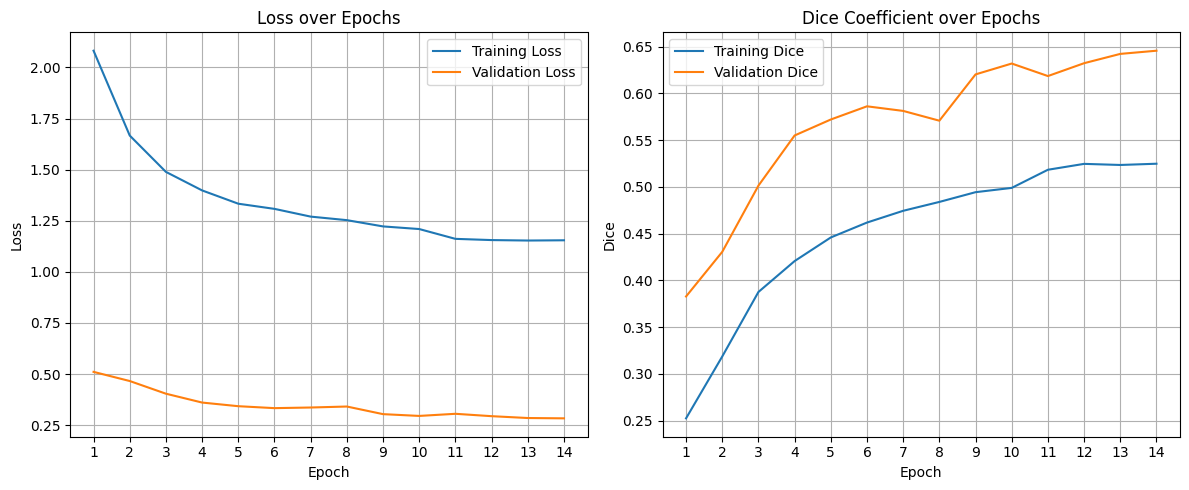

In [13]:
epochs_list = list(range(1, len(train_losses) + 1))  # or use len(val_dice) if that's more reliable

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=epochs_list)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Dice
plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dices, label='Training Dice')
plt.plot(epochs_list, val_dices, label='Validation Dice')
plt.xticks(ticks=epochs_list)
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
print("\n=== Evaluating on Test Set ===")

# Load the best model
checkpoint = torch.load('SEBattention1.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Instantiate loss criterion once
criterion = CombinedLoss(alpha=0.5, smooth=1e-6)

test_dice = 0.0
test_loss = 0.0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        # Forward pass
        outputs = model(images)
        
        # Handle deep supervision (should only return main output in eval mode)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        # Calculate loss and dice
        loss = criterion(outputs, masks)
        dice = dice_coefficient(outputs, masks)
        
        test_loss += loss.item()
        test_dice += dice.item()

avg_test_dice = test_dice / len(test_loader)
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Dice: {avg_test_dice:.4f}")
print(f"\n{'='*60}\n")


=== Evaluating on Test Set ===


KeyboardInterrupt: 